# Compare Binary Model to Mutli Model with Previous Violations History or Prev Violation + Stim Interactions

**Goal**: The goal of this notebook is to see if adding prev violation with interaction terms improves performance on l/r trials in the test set compared to the binary model.

I will also include a multi model without interactions to keep consistent across notebooks. This should have no improvement based on previous results  in `2023_10_10_compare_binary_multi.ipynb`

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import sys
[
    sys.path.append(str(folder))
    for folder in pathlib.Path("../src/").iterdir()
    if folder.is_dir()
]
from fitting_utils import create_violation_interaction_pairs
from experiment_compare_models import ExperimentCompareModels
from multiclass_logistic_regression import MultiClassLogisticRegression
from binary_logistic_regression import BinaryLogisticRegression
from model_visualizer import ModelVisualizerCompare
from design_matrix_generator import DesignMatrixGeneratorFilteredHistory, DesignMatrixGeneratorInteractions, DesignMatrixGeneratorPsytrack
sns.set_context("talk")
%load_ext autoreload
%autoreload 2

In [2]:
model_config = {
    "b_psytrack_features": {  # MODEL 1- psytrack binary base
        "model_class": BinaryLogisticRegression,
        "model_type": "binary",
        "design_matrix_generator": DesignMatrixGeneratorPsytrack,
        "filter_implementation": {},  # nothing to filter or drop
    },
    "m_psytrack_features": {  # MODEL 2- pystrack multi base
        "model_class": MultiClassLogisticRegression,
        "model_type": "multi",
        "design_matrix_generator": DesignMatrixGeneratorFilteredHistory,
        "filter_implementation": {"prev_violation": -1},  # no filter & drop column
        "lr_only_eval": True,  # only eval lr trials
    },
    "m_filter_prev_violation": {  # MODEL 3- with filt prev violation history
        "model_class": MultiClassLogisticRegression,
        "model_type": "multi",
        "design_matrix_generator": DesignMatrixGeneratorFilteredHistory,
        "filter_implementation": {
            "prev_violation": 1
        },  # filter column with animals tau
        "lr_only_eval": True,  # only eval lr trials
    },
    "m_filter_prev_violation_stim_itrx": {  # MODEL 4- with filt prev violation history and interactions
        "model_class": MultiClassLogisticRegression,
        "model_type": "multi",
        "design_matrix_generator": DesignMatrixGeneratorInteractions,
        "filter_implementation": {
            "prev_violation": 1
        },  # filter column with animals tau,
        "design_matrix_generator_args": {
            "interaction_pairs": create_violation_interaction_pairs(["s_a", "s_b"])
        },
        "lr_only_eval": True,  # only eval lr trials
    },
    "m_filter_prev_violation_all_itrx": {  # MODEL 4- with filt prev violation history and interactions
        "model_class": MultiClassLogisticRegression,
        "model_type": "multi",
        "design_matrix_generator": DesignMatrixGeneratorInteractions,
        "filter_implementation": {
            "prev_violation": 1
        },  # filter column with animals tau,
        "design_matrix_generator_args": {
            "interaction_pairs": create_violation_interaction_pairs(
                ["s_a", "s_b", "prev_sound_avg", "prev_correct", "prev_choice"]
            )
        },
        "lr_only_eval": True,  # only eval lr trials
    },
}
params = {
    "animals": None,
    "sigmas": [0.07, 0.13, 0.25, 0.5, 1, 2, 4, 8, 16],
    "random_state": 47,
    "null_mode": "binary",
    "eval_train": True,
    "tau_columns": ["prev_violation"],
    "model_config": model_config,
}

In [3]:
experiment = ExperimentCompareModels(params)
experiment.run()
experiment.save(
    file_name="2023_11_20_compare_binary_multi_prev_violation_interactions.pkl"
)

returning viol dataset for all animals

 >>>> evaluating animal W051 <<<<

 ***** evaluating model b_psytrack_features w/ sigma 0.07 *****
         Current function value: 22679.926435
         Iterations: 10
         Function evaluations: 74
         Gradient evaluations: 62

 ***** evaluating model b_psytrack_features w/ sigma 0.13 *****
         Current function value: 22811.479408
         Iterations: 10
         Function evaluations: 65
         Gradient evaluations: 53

 ***** evaluating model b_psytrack_features w/ sigma 0.25 *****
         Current function value: 22844.516006
         Iterations: 11
         Function evaluations: 75
         Gradient evaluations: 63

 ***** evaluating model b_psytrack_features w/ sigma 0.5 *****
         Current function value: 22854.531848
         Iterations: 11
         Function evaluations: 75
         Gradient evaluations: 63

 ***** evaluating model b_psytrack_features w/ sigma 1 *****
         Current function value: 22857.028142
       

In [4]:
# Comment out the models you don't want to plot
ORDER = [
    "b_psytrack_features",
    # "m_psytrack_features",
    # "m_filter_prev_violation",
    "m_filter_prev_violation_stim_itrx",
    # "m_filter_prev_violation_all_itrx",
]

mvc = ModelVisualizerCompare(experiment)
df = mvc.find_best_fit(group="model_name")
df["model_name"] = pd.Categorical(df["model_name"], categories=ORDER, ordered=True)

# Sort the DataFrame
df = df.sort_values("model_name")

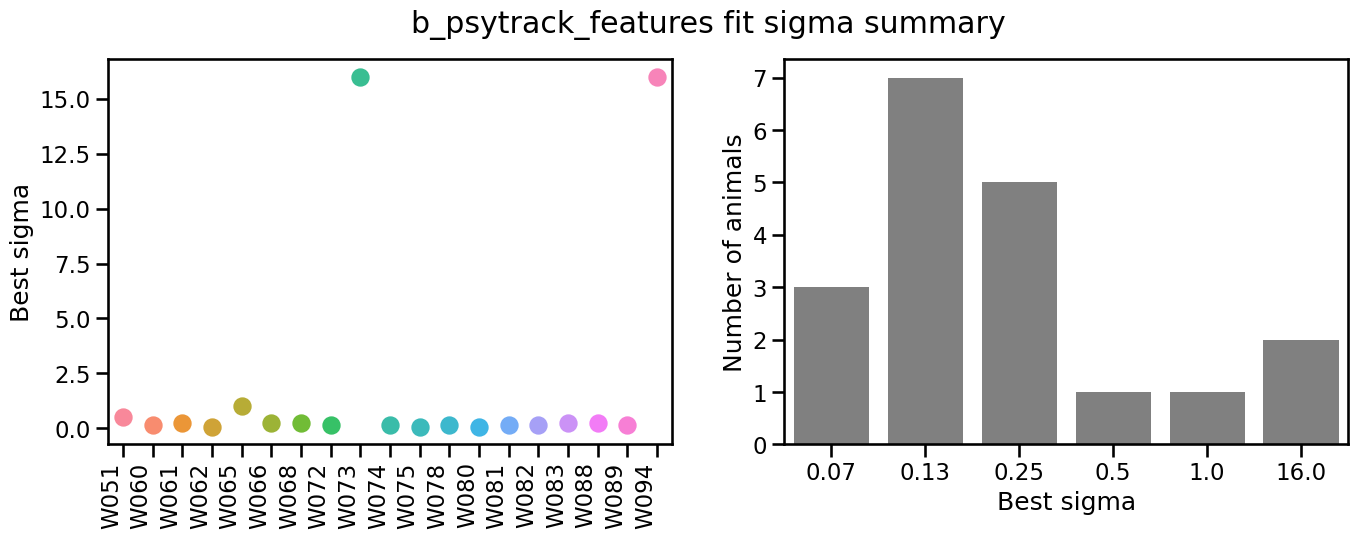

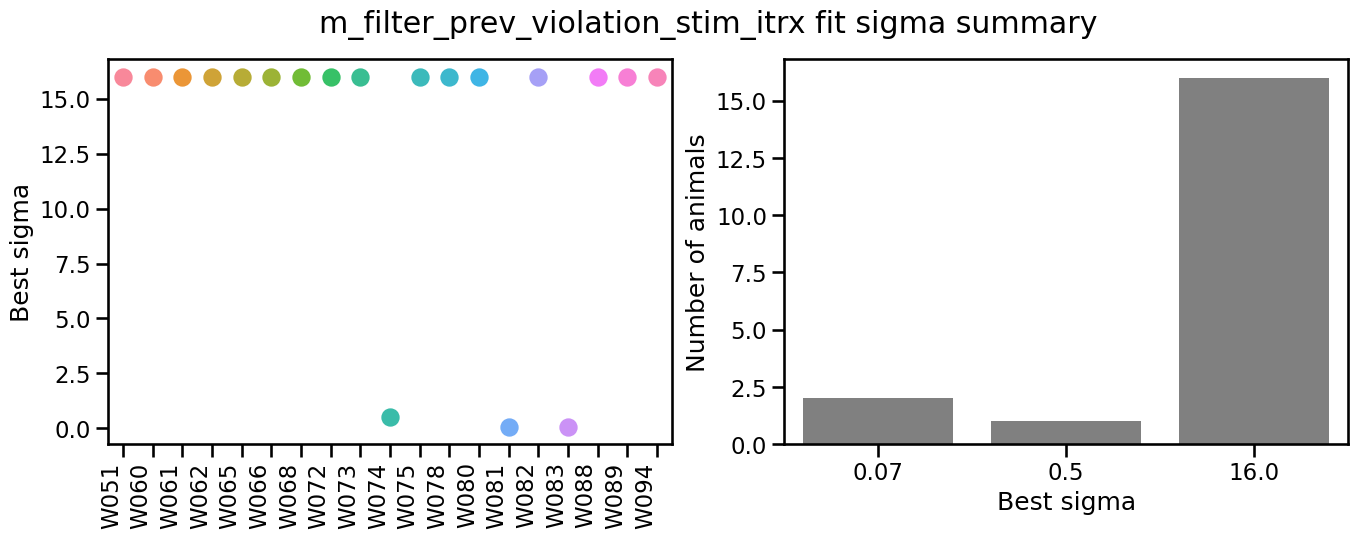

In [5]:
for model_name, model_df in df.groupby("model_name"):
    mvc.plot_sigma_summary(model_df, title=f"{model_name} fit sigma summary")

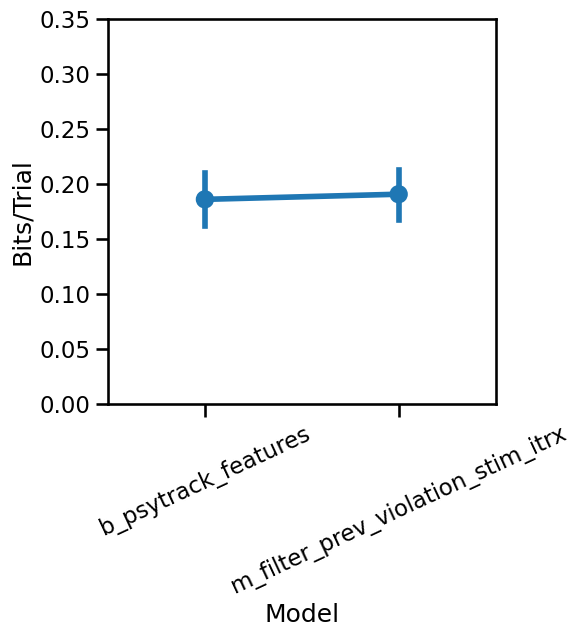

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
mvc.plot_model_comparison(hue=None, ax=ax, order=ORDER, ylim=(0, 0.35))

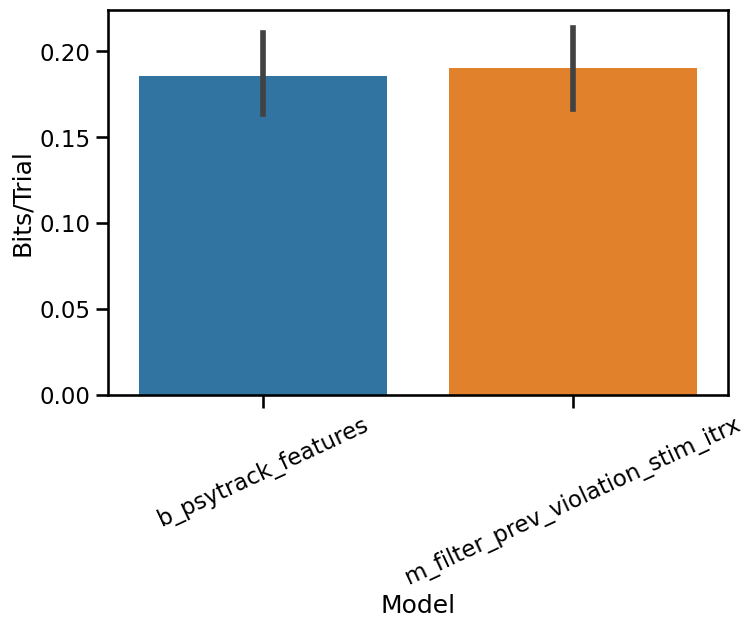

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
mvc.plot_model_comparison(type="bar", hue=None, ax=ax, order=ORDER)

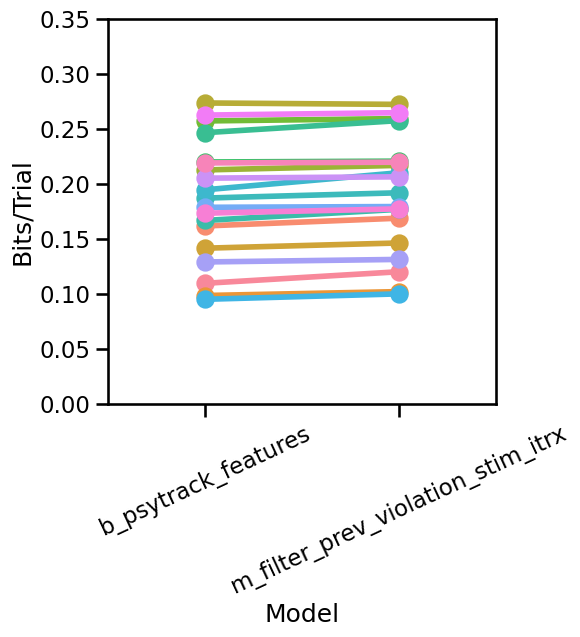

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
mvc.plot_model_comparison(hue="animal_id", ax=ax, order=ORDER, ylim=(0, 0.35))

In [9]:
mvc.compute_bits_per_trial_df()

,animal_id,model_name,nll,sigma,model_type,n_train_trials,n_test_trials,prev_violation_tau,log_like,bits_per_trial
0,W051,b_psytrack_features,6073.069550,0.5,binary,36958,9842,NaN,-6073.069550,0.109318
1,W051,m_filter_prev_violation,6043.136340,16.0,multi,43824,9842,6.0,-6043.136340,0.113705
2,W051,m_filter_prev_violation_all_itrx,5947.367226,16.0,multi,43824,9842,6.0,-5947.367226,0.127744
3,W051,m_filter_prev_violation_stim_itrx,6001.450873,16.0,multi,43824,9842,6.0,-6001.450873,0.119816
4,W051,m_psytrack_features,6073.820098,16.0,multi,43824,9842,-1.0,-6073.820098,0.109208
...,...,...,...,...,...,...,...,...,...,...
109,W094,m_filter_prev_violation,1796.303652,16.0,multi,20657,3323,6.0,-1796.303652,0.218171
110,W094,m_filter_prev_violation_all_itrx,1784.310643,16.0,multi,20657,3323,6.0,-1784.310643,0.223378
111,W094,m_filter_prev_violation_stim_itrx,1793.441358,16.0,multi,20657,3323,6.0,-1793.441358,0.219414
112,W094,m_psytrack_features,1797.275313,16.0,multi,20657,3323,-1.0,-1797.275313,0.217749
